# Naive Bayes On Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


### Objective
* To classify the positive and negative reviews.

###  How to classify?
* By applying vectorization techniques such as BOW, TF-IDF.
* Applying Naive bayes on above vectors. 
* Column used to check the Acuracy will be Score.
  - Positive review (rating 4-5)
  - Negative review (rating 1-2)

## Loading Data

In [1]:
%matplotlib inline
import warnings as wr
wr.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

con = sqlite3.connect('database.sqlite') #building connnection with database
review_data = pd.read_sql_query('''select * from Reviews where Score != 3''',con)#importing data from database

#function to replace rating with 1(+ve) or 0(-ve)
def Replace_rate(x):
    if x < 3:
        return 0
    else:
        return 1

OldScore = review_data['Score']
NewScore = OldScore.map(Replace_rate)
review_data['Score'] = NewScore
print('Review data is loaded with {0} rows and {1} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data.head()



Review data is loaded with 525814 rows and 10 columns


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Preprocessing

### Removing duplicate data

In [2]:
#Checking for duplicate data 
duplicate_data = pd.read_sql_query('''select UserId, ProductId, ProfileName, Time, Score, Text, count(*) as count from Reviews where 
Score != 3 group by UserId having count(*) > 1 ''',con)

duplicate_data.shape

(75346, 7)

In [3]:
#removing duplicate data
print('Data before de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data = review_data.sort_values('ProductId',axis = 0, ascending=True, inplace=False, kind='quicksort', na_position='last')

review_data = review_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print('Data after de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))

Data before de-duplication had 525814 rows and 10 columns
Data after de-duplication had 364173 rows and 10 columns


In [4]:
# Helpfulness denominator should be always greater than numerator
review_data = review_data[review_data.HelpfulnessNumerator <= review_data.HelpfulnessDenominator]
review_data.shape

(364171, 10)

### Cleaning the data
* Removing html tags
* Removing stopwords
* Converting words to lower case
* Removing alphanumeric value 
* Lemmitizing the data

In [5]:
import re
import os
import nltk
import string
from tqdm import tqdm
from nltk.corpus import stopwords 

sno = nltk.stem.SnowballStemmer('english')#initialise stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


if not os.path.isfile('final.sqlite'):
    final_string = []
    for i, sent in enumerate(tqdm(review_data['Text'].values)):
        filtered_sentence=[]
        sent = cleanhtml(sent)
        for w in sent.split():
            for cleanwords in cleanpunc(w).split():
                #we are spliting the data two time because after first splitting there may be a possibility that we can get a word
                # 'abc.def' which after the second split will become two words 'abc' 'def'
                if((cleanwords.isalpha()) and (len(cleanwords)>2)): # there is no adjective with length 2
                    if(cleanwords.lower() not in stop):
                        s=(sno.stem(cleanwords.lower())).encode('utf8')
                        filtered_sentence.append(s)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:38<00:00, 1076.76it/s]


In [6]:
#storing the data in a database(.sqlite file)
review_data['CleanedText'] = final_string
review_data['CleanedText']=review_data['CleanedText'].str.decode("utf-8")
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
review_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [7]:
#importing preprocessed data into a new dataframe
conn = sqlite3.connect('final.sqlite')
preprocessed_data = pd.read_sql_query('''select * from Reviews''',conn)
print(preprocessed_data.shape)
preprocessed_data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [8]:
#https://www.programiz.com/python-programming/datetime/strftime
#converting given time with format %m/%d/%Y, %H:%M:%S
from datetime import datetime

timestamp = preprocessed_data['Time']
time_data=[]
for i in timestamp:
    date_time = datetime.fromtimestamp(i)
    d = date_time.strftime("%m/%d/%Y, %H:%M:%S")
    time_data.append(d)

preprocessed_data['Time'] = time_data

In [9]:
#sorting values according to time
processed_data = preprocessed_data.sort_values('Time',axis=0).reset_index(drop=True)
processed_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,516061,557949,B0000DJDL4,A1Y20KNCR0SZA1,"Dessartfamily ""grandmasoven""",8,9,1,"01/01/2004, 05:30:00",The best Kringles ever,Others try to make kringles but there is only ...,other tri make kringl one bakeri make real dan...
1,420655,454893,B00032EGHI,A1XBSM55RTS2IT,"Celine Johnson ""C. Johnson""",8,8,1,"01/01/2006, 05:30:00",Vanilla Coke is On Hiatus,I just read a press release from Coca-Cola tha...,read press releas vanilla coke put hiatus best...
2,309826,335493,B0002HVDNY,A3FVAWZNKW9GX,"A.Trendl HungarianBookstore.com ""What should ...",1,2,1,"01/01/2006, 05:30:00",Slowly Smoked Pork is Delicious,I buy Karaj Hungarian Pork Loin regularly at o...,buy karaj hungarian pork loin regular local hu...
3,473796,512403,B0000D15YQ,A1DEBB7A9T1XS,"Luca Varallo ""lvarallo""",12,13,1,"01/01/2006, 05:30:00",Got to be an Italian to drink this,The name sanbitter (san pellegrino bitter) tel...,name sanbitt san pellegrino bitter tell typic ...
4,136175,147794,B0001BVO9Y,A2MWBSYJR74S75,R. Murphy,12,12,1,"01/01/2006, 05:30:00",Wonderful on it's own or mixed in drinks,This is the finest Cola I have found yet.<br /...,finest cola found yet small store near sell bo...


### Splitting Data Based on Time

In [10]:
#splitting the data into train and test set
import math
%matplotlib inline
import warnings as wr
wr.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

X = processed_data['CleanedText']
Y = processed_data['Score']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

### Hyperparameter tuning for alpha using gridsearch

In [11]:
# this function is defined to reduce the coding effort to find k value for each vectorization technique
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit
import math
def optimal_alpha_val(x,y):
    
    a = [.00001,.0001,.001,.01,1,10,100,1000,10000]
    alpha = [math.log(i) for i in a]
    naive = MultinomialNB()
    tscv = TimeSeriesSplit(n_splits=10)#https://stackoverflow.com/questions/53252832/how-to-find-top-features-from-naive-bayes-using-sklearn-pipeline
    parameters = {'alpha': a}
    clf = GridSearchCV(naive, parameters, cv=tscv, scoring='roc_auc')
    clf.fit(x, y)
    
    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    
    print('Best tunned parameter is',clf.best_params_)
    print('Train data accuracy is %f%% '%(clf.best_score_*100))
    
    plt.plot(alpha, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    
    plt.plot(alpha, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return clf.best_params_

## BOW

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
x_train_bow = count_vect.fit_transform(x_train)
x_test_bow = count_vect.transform(x_test)
print(x_train_bow.shape)
print(x_test_bow.shape)

(243994, 58493)
(120177, 58493)


Best tunned parameter is {'alpha': 1}
Train data accuracy is 89.642484% 


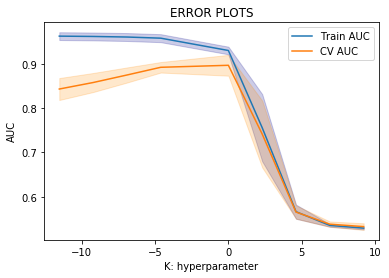

In [13]:
alpha=optimal_alpha_val(x=x_train_bow,y=y_train)

### Testing Alpha on test data

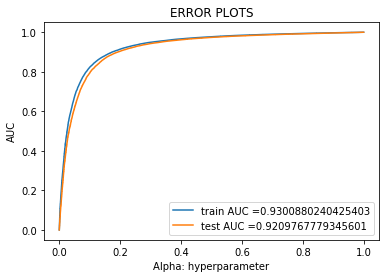

In [14]:
from sklearn.metrics import roc_curve, auc
naive = MultinomialNB(alpha=alpha['alpha'])
naive.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, naive.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix For Train Data

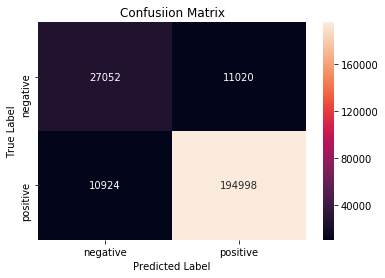

In [15]:
# predict the response
y_pred_bow = naive.predict(x_train_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [16]:
print(classification_report(y_train ,y_pred_bow))

             precision    recall  f1-score   support

          0       0.71      0.71      0.71     38072
          1       0.95      0.95      0.95    205922

avg / total       0.91      0.91      0.91    243994



### Confusion Matrix on Test Data

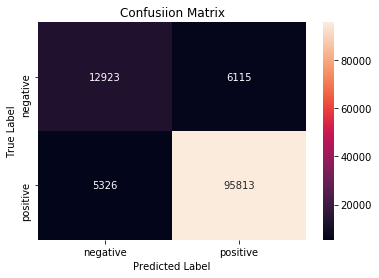

In [17]:
# predict the response
y_pred_bow = naive.predict(x_test_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [18]:
print(classification_report(y_test ,y_pred_bow))

             precision    recall  f1-score   support

          0       0.71      0.68      0.69     19038
          1       0.94      0.95      0.94    101139

avg / total       0.90      0.90      0.90    120177



## Top 10 Positive and Negative Features

In [19]:
feature_names =count_vect.get_feature_names()
max_ind_pos=np.argsort((naive.feature_log_prob_)[1])[::-1][0:10] 
max_ind_neg=np.argsort((naive.feature_log_prob_)[0])[::-1][0:10]

print(" Important words in Positive Reviews ")
for i in max_ind_pos:
    print(i,feature_names[i])
print("-----------------------------------------")
print("Important words in Negative reviews")
for i in max_ind_neg:
    print(i,feature_names[i])

 Important words in Positive Reviews 
29411 like
50749 tast
21652 good
19036 flavor
30077 love
22119 great
54710 use
36095 one
40458 product
52857 tri
-----------------------------------------
Important words in Negative reviews
50749 tast
29411 like
40458 product
36095 one
19036 flavor
52857 tri
57401 would
54710 use
21652 good
10329 coffe


### Feature Engineering BOW

In [48]:
#adding a column i.e Count of words in a review text to check if the performance of model increases or not
x_train_fe = x_train[0:10000]
y_train_fe = y_train[0:10000]
x_test_fe = x_test[0:10000]
y_test_fe = y_test[0:10000]
count_train_words=[] 
for i in x_train_fe: 
    a=[] 
    a.append(len(i.split())) 
    count_train_words.append(a)
count_test_words=[] 
for i in x_test_fe: 
    a=[] 
    a.append(len(i.split())) 
    count_test_words.append(a) 
    
count_vect = CountVectorizer()

x_train_bow_fe = count_vect.fit_transform(x_train_fe)
x_test_bow_fe = count_vect.transform(x_test_fe) 
x_train_bow_fe = x_train_bow_fe.todense() 
x_test_bow_fe = x_test_bow_fe.todense() 
x_train_bow_fe=np.hstack((x_train_bow_fe,count_train_words)) 
x_test_bow_fe=np.hstack((x_test_bow_fe,count_test_words)) 

In [49]:
# standardizing the data so that the added feature will not behave as a outlier
from sklearn.preprocessing import StandardScaler
import warnings as wr
wr.filterwarnings('ignore')
x_train_bow_stand_fe = StandardScaler(with_mean = False).fit_transform(x_train_bow_fe)
x_test_bow_stand_fe = StandardScaler(with_mean = False).fit_transform(x_test_bow_fe)

Best tunned parameter is {'alpha': 10}
Train data accuracy is 68.063571% 


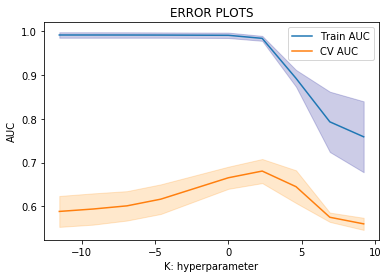

In [53]:
alpha=optimal_alpha_val(x=x_train_bow_stand_fe,y=y_train_fe)

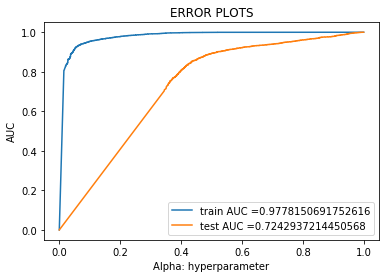

In [54]:
from sklearn.metrics import roc_curve, auc
naive = MultinomialNB(alpha=alpha['alpha'])
naive.fit(x_train_bow_stand_fe,y_train_fe)
train_fpr, train_tpr, thresholds = roc_curve(y_train_fe, naive.predict_proba(x_train_bow_stand_fe)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_fe, naive.predict_proba(x_test_bow_stand_fe)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix of Train Data

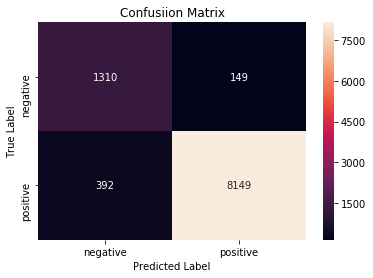

---------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.77      0.90      0.83      1459
          1       0.98      0.95      0.97      8541

avg / total       0.95      0.95      0.95     10000



In [56]:
# predict the response
y_pred_bow_fe = naive.predict(x_train_bow_stand_fe)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train_fe,y_pred_bow_fe)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('---------------------------------------------------------------')
print(classification_report(y_train_fe ,y_pred_bow_fe))


### Confusion Matrix on Test Data

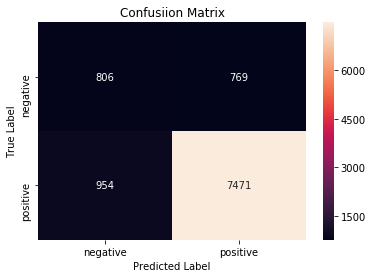

---------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.46      0.51      0.48      1575
          1       0.91      0.89      0.90      8425

avg / total       0.84      0.83      0.83     10000



In [57]:
# predict the response
y_pred_bow_fe = naive.predict(x_test_bow_stand_fe)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test_fe,y_pred_bow_fe)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('---------------------------------------------------------------')
print(classification_report(y_test_fe ,y_pred_bow_fe))


## TF-IDF

In [58]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
x_train_tfidf = tf_idf_vect.fit_transform(x_train)
x_test_tfidf = tf_idf_vect.transform(x_test)
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(243994, 145294)
(120177, 145294)


Best tunned parameter is {'alpha': 0.01}
Train data accuracy is 93.232790% 


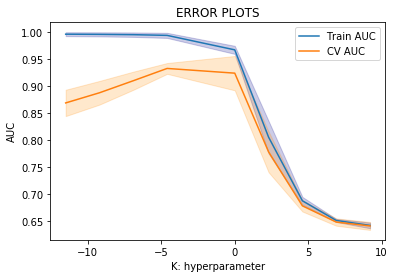

In [59]:
alpha=optimal_alpha_val(x=x_train_tfidf,y=y_train)

###  Testing alpha on test data

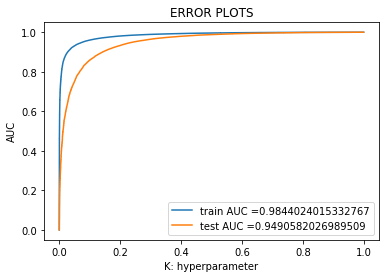

In [60]:
from sklearn.metrics import roc_curve, auc
naive = MultinomialNB(alpha=alpha['alpha'])
naive.fit(x_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, naive.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

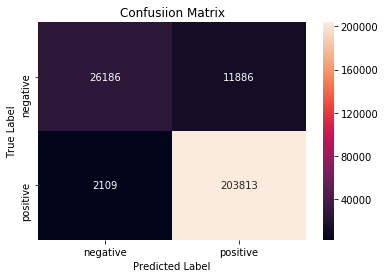

In [61]:
# predict the response
y_pred_tfidf = naive.predict(x_train_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [62]:
print(classification_report(y_train ,y_pred_tfidf))

             precision    recall  f1-score   support

          0       0.93      0.69      0.79     38072
          1       0.94      0.99      0.97    205922

avg / total       0.94      0.94      0.94    243994



### Confusion Matrix on Test Data

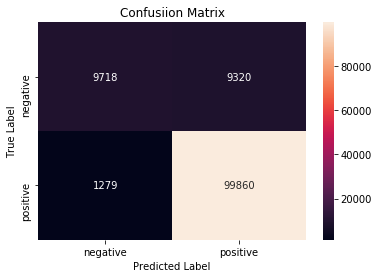

In [63]:
# predict the response
y_pred_tfidf = naive.predict(x_test_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [64]:
print(classification_report(y_test ,y_pred_tfidf))

             precision    recall  f1-score   support

          0       0.88      0.51      0.65     19038
          1       0.91      0.99      0.95    101139

avg / total       0.91      0.91      0.90    120177



###  Top 10 Positive and Negative values using TF-IDF Vectorizer

In [65]:
feature_names =tf_idf_vect.get_feature_names()
max_ind_pos=np.argsort((naive.feature_log_prob_)[1])[::-1][0:10] 
max_ind_neg=np.argsort((naive.feature_log_prob_)[0])[::-1][0:10]

print(" Important words in Positive Reviews ")
for i in max_ind_pos:
    print(i,feature_names[i])
print("-----------------------------------------")
print("Important words in Negative reviews")
for i in max_ind_neg:
    print(i,feature_names[i])

 Important words in Positive Reviews 
74731 love
57151 great
124759 tast
70771 like
55292 good
126035 tea
47908 flavor
24618 coffe
135210 use
98950 product
-----------------------------------------
Important words in Negative reviews
124759 tast
98950 product
70771 like
143284 would
47908 flavor
87890 one
24618 coffe
132490 tri
17307 buy
89447 order


### Feature Engineering Tf-Idf

In [66]:
#adding a column i.e Count of words in a review text to check if the performance of model increases or not
x_train_fe = x_train[0:10000]
y_train_fe = y_train[0:10000]
x_test_fe = x_test[0:10000]
y_test_fe = y_test[0:10000]
count_train_words=[] 
for i in x_train_fe: 
    a=[] 
    a.append(len(i.split())) 
    count_train_words.append(a)
count_test_words=[] 
for i in x_test_fe: 
    a=[] 
    a.append(len(i.split())) 
    count_test_words.append(a) 
    
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)

x_train_tfidf_fe = tf_idf_vect.fit_transform(x_train_fe)
x_test_tfidf_fe = tf_idf_vect.transform(x_test_fe) 
x_train_tfidf_fe = x_train_tfidf_fe.todense() 
x_test_tfidf_fe = x_test_tfidf_fe.todense() 
x_train_tfidf_fe=np.hstack((x_train_tfidf_fe,count_train_words)) 
x_test_tfidf_fe=np.hstack((x_test_tfidf_fe,count_test_words)) 

In [67]:
# standardizing the data so that the added feature will not behave as a outlier
from sklearn.preprocessing import StandardScaler
import warnings as wr
wr.filterwarnings('ignore')
x_train_tfidf_stand_fe = StandardScaler(with_mean = False).fit_transform(x_train_tfidf_fe)
x_test_tfidf_stand_fe = StandardScaler(with_mean = False).fit_transform(x_test_tfidf_fe)

Best tunned parameter is {'alpha': 100}
Train data accuracy is 84.094337% 


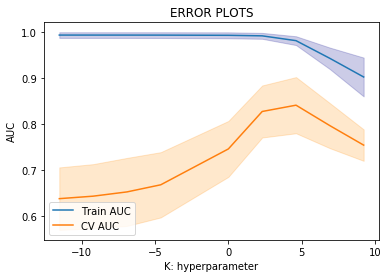

In [68]:
alpha=optimal_alpha_val(x=x_train_tfidf_stand_fe,y=y_train_fe)

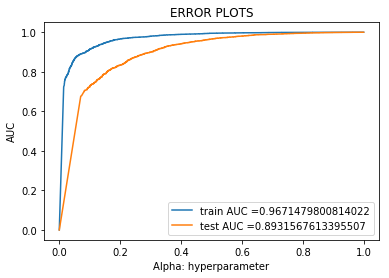

In [69]:
from sklearn.metrics import roc_curve, auc
naive = MultinomialNB(alpha=alpha['alpha'])
naive.fit(x_train_tfidf_stand_fe,y_train_fe)
train_fpr, train_tpr, thresholds = roc_curve(y_train_fe, naive.predict_proba(x_train_tfidf_stand_fe)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_fe, naive.predict_proba(x_test_tfidf_stand_fe)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix of Train Data

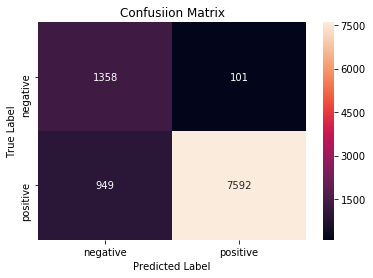

---------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.59      0.93      0.72      1459
          1       0.99      0.89      0.94      8541

avg / total       0.93      0.90      0.90     10000



In [70]:
# predict the response
y_pred_tfidf_fe = naive.predict(x_train_tfidf_stand_fe)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train_fe,y_pred_tfidf_fe)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('---------------------------------------------------------------')
print(classification_report(y_train_fe ,y_pred_tfidf_fe))


### Confusion Matrix of Test Data

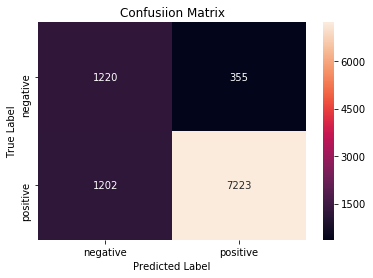

---------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.50      0.77      0.61      1575
          1       0.95      0.86      0.90      8425

avg / total       0.88      0.84      0.86     10000



In [71]:
# predict the response
y_pred_tfidf_fe = naive.predict(x_test_tfidf_stand_fe)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test_fe,y_pred_tfidf_fe)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('---------------------------------------------------------------')
print(classification_report(y_test_fe ,y_pred_tfidf_fe))


## Conclusion

In [46]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer ", "Model", "Hyper Parameter/alpha", "AUC"]
x.add_row(["BOW", "MultinomialNB", 1 , .92])
x.add_row(["TF-IDF", "MultinomialNB", .01  , .94])

print(x)

+-------------+---------------+-----------------------+------+
| Vectorizer  |     Model     | Hyper Parameter/alpha | AUC  |
+-------------+---------------+-----------------------+------+
|     BOW     | MultinomialNB |           1           | 0.92 |
|    TF-IDF   | MultinomialNB |          0.01         | 0.94 |
+-------------+---------------+-----------------------+------+


 ## Observation

## BOW
- While applying additive smoothing the optimal alpha value for BOW is 1
- From the ROC curve we can see that using alpha = 1 the AUC of train and test data is approximately same
- The f1-score for both train and test data comes approx 91% which proves that alpha = 1 is the best parameter for additive       smoothing
- like,tast,good,flavor,use,one,product,tri are the most important words used in positive as well as in negative reviews

### Feature Engineering
- We can see a decline in performance of model after adding a new feature (count of words in the review text)
- The AUC of test is decreased significantly after applying a new feature in comparision to the previous model
- Thus this new feature is not a good feature for this model

## TF-IDF
- While applying additive smoothing the optimal alpha value for TF-IDF is .01
- From the ROC curve we can see that AUC of test in TF-IDF vectorizer is more than of BOW vectorizer
- tast,like,flavor,coffe,product are the most important words used in positive as well as in negative reviews

### Feature Engineering
- As we have used less number of points in feature engineering but after adding the new feature the performace of model is         same
- After adding the new feature the alpha value is increased 10000 times which was increased 10 times in BOW feature               engineering

-----------------------------------------------------------------------------------------------------------

- Multinomial naive Bayes does not support -ve points so we have only used BOW and TF-IDF
- Alpha is very low if we use sparse matrices instead of Dense Matrices
- AUC for TF-IDF is slightly better in comparision with AUC of BOW
- Love and Great are the two most important positive words also not used in negative reviews
- Would is the most important negative word which is also not used in positive reviews